## Libraries

### Install packages and download models

In [5]:
!pip install llama-cpp-python
!pip install bertopic
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 14.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


### Imports

In [6]:
import numpy as np
import pandas as pd
from gensim import corpora, models
import spacy
from spacy.lang.en import stop_words
from tqdm import tqdm
from transformers import pipeline
import matplotlib.pyplot as plt
import os
from llama_cpp import Llama
import logging
import re

In [7]:
tqdm.pandas()

# spaCy NLP
nlp = spacy.load("en_core_web_md")

# Llama LLM
llm = Llama.from_pretrained(
    repo_id="bartowski/Llama-3.2-3B-Instruct-GGUF",
  filename="Llama-3.2-3B-Instruct-Q4_K_M.gguf",   # 2GB
    verbose=False,
)

print(f"Using model: {llm.metadata.get('general.name')}")
print(f"Stored at: {llm.model_path}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Llama-3.2-3B-Instruct-Q4_K_M.gguf:   0%|          | 0.00/2.02G [00:00<?, ?B/s]

llama_new_context_with_model: n_ctx_per_seq (512) < n_ctx_train (131072) -- the full capacity of the model will not be utilized


Using model: Llama 3.2 3B Instruct
Stored at: /root/.cache/huggingface/hub/models--bartowski--Llama-3.2-3B-Instruct-GGUF/snapshots/5ab33fa94d1d04e903623ae72c95d1696f09f9e8/./Llama-3.2-3B-Instruct-Q4_K_M.gguf


## Preprocess text

### Filter out non-English documents

In [ ]:
# https://huggingface.co/papluca/xlm-roberta-base-language-detection
model_ckpt = "papluca/xlm-roberta-base-language-detection"
pipe = pipeline("text-classification", model=model_ckpt)

df_blogs = pd.read_csv("blogs.csv").dropna(subset="blog")
for i, row in tqdm(df_blogs.iterrows()):
    blog = row["blog"]

    blog = blog.strip()
    lang = pipe(blog, truncation=True)

    df_blogs.loc[i, "blog"] = blog
    df_blogs.loc[i, "lang"] = lang[0]["label"]

df_blogs = df_blogs[df_blogs["lang"] == "en"]
df_blogs.to_csv("blogs.csv")

Device set to use cpu
3138it [58:25,  1.12s/it]


### Apply standard preprocessing

In [ ]:
stop_words_to_use = list(stop_words.STOP_WORDS)
stop_words_to_use += ["ride", "rides", "riding", "cycling", "bycycling", "tour", "touring", "day", "bike", "bikes", "road", "get", "go", "mile", "miles", "km", "kms", "metre", "like", "way", "good", "come", "look", "nice", "think", "trip", "know", "see", "great", "today", "distance", "malawi", "zambia", "auckland", "strasbourg", "pyrenees", "bordeaux", "andorra", "paris", "france"]

In [ ]:
# https://spacy.io/usage/linguistic-features


def preprocess_text(file_path, nlp, stop_word_removal=True, non_alpha_removal=True, lemmatization=True, lowercasing=True, stop_words_to_use=[]):
    df_blogs = pd.read_csv(file_path)
    documents = []

    for i, row in tqdm(df_blogs.iterrows()):
        doc = nlp(row["blog"]) # Convert to spaCy doc

        if len(doc) > 1:
            if non_alpha_removal: # Remove non alpha characters
                doc = [token for token in doc if token.is_alpha]

            if lemmatization: # Lemmatize words
                doc = [token.lemma_ for token in doc]

            if stop_word_removal: # Remove stop words
                doc = [token for token in doc if token not in stop_words_to_use]

            if lowercasing: # Lowercase words
                doc = [token.lower() for token in doc]

            documents.append(doc)

    # https://radimrehurek.com/gensim/auto_examples/core/run_corpora_and_vector_spaces.html
    dictionary = corpora.Dictionary(documents)
    dictionary.filter_extremes(no_below=2) # Filter out tokens appearing only once
    corpus = [dictionary.doc2bow(doc) for doc in documents]

    dictionary.save("dictionary.dict")
    corpora.MmCorpus.serialize("corpus.mm", corpus)


preprocess_text("blogs.csv", nlp, stop_words_to_use=stop_words_to_use)


## Explore dictionary

In [ ]:
# https://radimrehurek.com/gensim/auto_examples/core/run_topics_and_transformations.html
dictionary = corpora.Dictionary.load("dictionary.dict")
corpus = corpora.MmCorpus("corpus.mm")

word_freq = {k: v for k, v in sorted(dictionary.cfs.items(), key=lambda item: item[1], reverse=True)}
for id in list(word_freq.keys())[:50]:
    print(dictionary[id])

stop
town
find
start
hill
head
little
leave
pass
place
night
turn
long
wind
rain
people
lot
climb
right
park
feel
route
big
hour
river
water
bit
want
tell
thing
eat
end
home
new
stay
pretty
area
camp
decide
use
lunch
walk
old
morning
work
meet
rest
try
far
couple


## Modelling

In [ ]:
# Allow logging
logging.basicConfig(filename='gensim.log', format='%(asctime)s:%(levelname)s:%(message)s', level=logging.INFO)


def clear_logfile():
    # To empty the log file
    with open("gensim.log", "w"):
        pass


def parse_logfile():
    """Parse gensim.log to extract the log-likelihood scores.

    Returns:
        A list of log-likelihood scores.
    """
    matcher = re.compile(r'(-*\d+\.\d+) per-word .* (\d+\.\d+) perplexity')
    likelihoods = []
    with open('gensim.log') as source:
        for line in source:
            match = matcher.search(line)
            if match:
                likelihoods.append(float(match.group(1)))
    return likelihoods

### Modelling

Topic 0: gum, nugget, excerpt, emu, fossil, ochoco, dayville, sumpter, berea, perth
Topic 1: mckinsey, finn, butte, celebration, elevation, beau, gain, encouraging, chester, casino
Topic 2: springbrook, simon, rosalia, boone, fairground, brooks, bugger, hillsboro, kg, hobart
Topic 3: savour, hangover, faithful, invermere, newcastle, gin, stuart, link, erie, jen
Topic 4: ernie, unity, anglesea, marion, carlsbad, spearfish, part, whitefish, waterfront, spain
Topic 5: guffey, sprocket, blah, cochrane, barbara, carol, london, â, xmas, ernie
Topic 6: sammy, christopher, patrick, bombala, lander, alison, photo, charlottesville, napier, kirby
Topic 7: roadside, falls, clark, ern, missouri, anna, texas, flower, joyce, phil
Topic 8: melbourne, francois, rotorua, st, jean, h, molly, pj, km, total
Topic 9: start, climb, river, find, wind, pass, stop, rain, hill, town


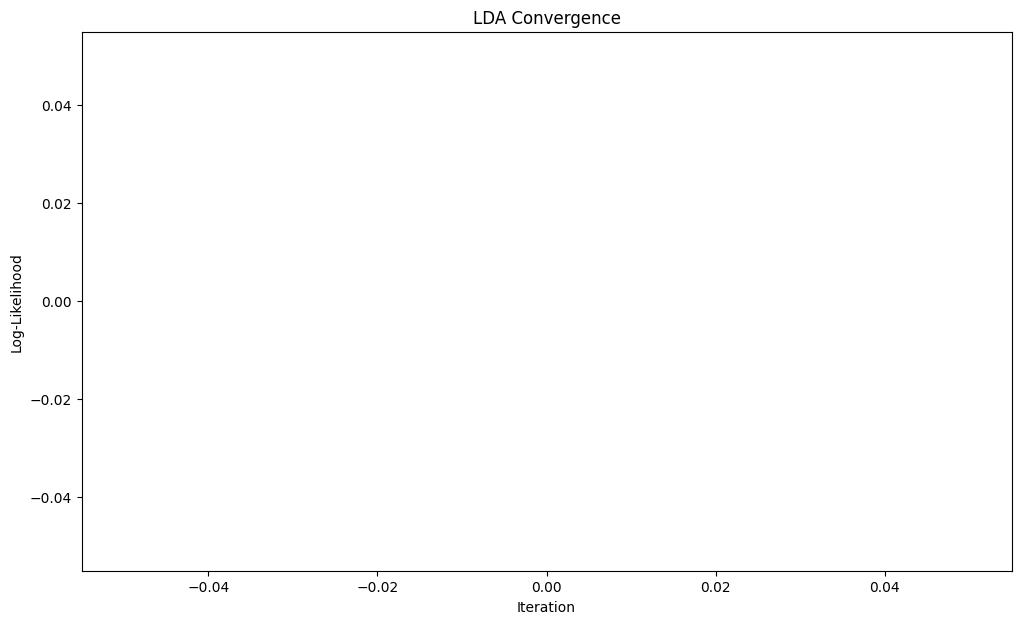

In [ ]:
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

# # https://radimrehurek.com/gensim/models/ldamodel.html
clear_logfile()
lda = models.LdaModel(corpus_tfidf, num_topics=10, id2word=dictionary, passes=100)
likelihoods = parse_logfile()

# Plot likelihoods for convergence
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(likelihoods)
ax.set(title="LDA Convergence", xlabel="Iteration", ylabel="Log-Likelihood")

# Print most important words per topic
topics = lda.get_topics()
for topic in range(10):
    topic_probs = topics[topic, :]
    print(f"Topic {topic}: {', '.join([dictionary[i] for i in np.argsort(topic_probs)[-10:]])}")

In [ ]:
# https://maartengr.github.io/BERTopic/getting_started/tips_and_tricks/tips_and_tricks.html
# https://maartengr.github.io/BERTopic/getting_started/best_practices/best_practices.html

from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import KeyBERTInspired
from hdbscan import HDBSCAN
from bertopic import BERTopic

In [ ]:
df_blogs = df_blogs.reset_index(drop=True)

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(df_blogs.blog)

In [ ]:
hdbscan_model = HDBSCAN(min_cluster_size=50) # Clustering step
vectorizer_model = CountVectorizer(stop_words=stop_words_to_use) # Tokenizer step
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True) # c-TF-IDF step
representation_model = KeyBERTInspired() # Fine-tuning step
topic_model = BERTopic(embedding_model=embedding_model, hdbscan_model=hdbscan_model, vectorizer_model=vectorizer_model, ctfidf_model=ctfidf_model, representation_model=representation_model)
topics, probs = topic_model.fit_transform(df_blogs.blog, embeddings)

In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1352,-1_campground_lake_hills_park,"[campground, lake, hills, park, climb, camp, l...",[The Data: Miles: 87.00Time: 8:43:14 (many)Max...
1,0,1560,0_trail_highway_park_campground,"[trail, highway, park, campground, downhill, h...",[It was real foggy out this morning. Before ...
2,1,55,1_trips_bicycling_biking_bicycle,"[trips, bicycling, biking, bicycle, vacation, ...",[My wife wasn't overly thrilled about it; how...


In [ ]:
topic_model.visualize_topics()

IndexError: arrays used as indices must be of integer (or boolean) type

In [13]:
def get_blog_topics(blog):
  res = llm.create_chat_completion(messages=[
          {
              "role": "user",
              "content": f"Please analyze the follow blog: {blog}"
          },
          {
              "role": "system",
              "content": "You are an assistant who analyzes bicycle touring blogs and concisely summarizes the touring styles. This may include things such as where or how people sleep (e.g. tent, hotels, wildcamping, campgrounds, etc.), as well as whether they mostly ride on the road or on gravel, how many people the blogger travels with, or anything else you think may be relevant. Be concise, mentioning only words relevant to touring style. If there are none, simply return nothing. The location of the blogger is not of interest to you."
          }
      ],
  )

  return res["choices"][0]["message"]["content"]

In [ ]:
df_blogs = pd.read_csv("blogs.csv")

for index, row in df_blogs.iterrows():
  print(f"{index}: {get_blog_topics(row['blog'][:512])}")


0: Wildcamping, gravel roads, day walk.
1: Road cycling, following major highway, avoiding minor routes, rough weather, using hard shoulder.
2: Wildcamping.
3: Wildcamping, no campsite, pub drop-off, highway ride.
4: Flat roads, small towns, wild camping, late breakfast, 10km climb, road riding.
5: * Extra bike cost
* Wild camping
* Tent
* Road riding
* Gravel riding
* Campgrounds
* Hotel
* Wild camping
6: Mixed terrain, possible wildcamping, possibly road cycling, possibly gravel cycling.
7: Wildcamping, gravel road, tent area.
8: Gravel, wildcamping, road cycling.
9: Wildcamping, no services, forced rest stops.
10: Bouncing boat.
11: Wildcamping.
12: Wildcamping, gravel roads, no facilities, mountainous terrain.
13: Road, highway, cafe, tea, wild camping (implied by 'early coffee stop' and 'another cafe turned up on time').
14: Road, low wind, gentle rises, cafe, wild camping.
15:  Gentle, quiet roads, pleasant temperatures, total cloud cover, no rain, finished by lunchtime, wildcamp

Idea: somehow score how relevant sentences are to touring style and then remove sentences below a certain threshold. Then apply topic modelling.

In [12]:
print(df_blogs.loc[0, "blog"])

At Owhango after 20kms we went across latitude 39degree south, so the sign by the road said. Then later on into view came the volcanic mountains of Mt Tongariro 1967metres and Mt Ngauruhoe 2291metres (these are both extinct) just as the clouds had quickly dispearsed from them to give clear blue skies and it was warming up a lot as well. The Tongariro Crossing is a 6-8hr walk across these two volcano's and is classified as 'one of the  world's greatest one day walks'. All very subjective but it is an excellent walk through a very unique landscape. We did it 2 years ago on a day very much like today. Further up the road the snow capped volcano of Mt Ruapehu at 2797metres (this one is still active, though currently dormant) came into full view - what an impressive sight. It was in our view for most of the rest of the day.      But just as things were looking really good they went downhill from here or rarther uphill and very uphill. The railway line  at Raurima goes on lots of little spir